In [1]:
import numpy as np
import pandas as pd
import queue
import threading
from os import listdir
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm,LogNorm
import matplotlib.cm as cm
from importlib import reload
import tqdm.notebook as tqdm

In [2]:
import fast_binning

12Hz blower frequency data
- Data processing pipeline:
    Setup appropriate bins (semi-automated) -> expand with additional variables -> compute binning

In [3]:
dir_ = "onderive_data_2/12Hz/"

In [4]:
test_path = dir_ + "layer360.csv"
test = pd.read_csv(test_path,header=0,index_col=0)
var_labels = test.loc[:,"Photodiode":].columns.drop(["Z","Frame","Layer"])
var_labels = var_labels.append(pd.Index(["Distance traversed"]))
x_grid,y_grid = fast_binning.optimal_grid(["X","Y"],
                                          test,
                                          [4,4],
                                          sub_divisions=6,
                                          aux_variable="P",
                                          tol=1000.0)

In [5]:
XY_data = fast_binning.DataBins(["X","Y"],[x_grid,y_grid],var_labels)
th_data = fast_binning.DataBins(["Orientation"],[np.linspace(-np.pi,np.pi,41,endpoint=True)],var_labels)
Zl_data = fast_binning.DataBins(["Layer"],[np.arange(0,181,9)-0.5],var_labels)

In [6]:
for file in tqdm.tqdm(listdir(dir_)):
    df = pd.read_csv(dir_ + file,header=0,index_col=0,engine='c')
    df = fast_binning.expand_df(df)
    fast_binning.process_dataframe(df,XY_data,th_data,Zl_data)

  0%|          | 0/180 [00:00<?, ?it/s]

30Hz blower frequency data
- repeat the data processing pipeline used above. 

In [7]:
dir_ = "onderive_data_2/30Hz/"

XY_data_30Hz = fast_binning.DataBins(["X","Y"],[x_grid,y_grid],var_labels)
th_data_30Hz = fast_binning.DataBins(["Orientation"],[np.linspace(-np.pi,np.pi,41,endpoint=True)],var_labels)
Zl_data_30Hz = fast_binning.DataBins(["Layer"],[np.arange(0,181,9)-0.5],var_labels)

We can visualise these bins for different dependent variables (in this case, different metrics), and different quantities for each bin (e.g. mean values per bin, std per bin, etc.).

In [8]:
for file in tqdm.tqdm(sorted(listdir(dir_),
                             key=lambda f: int(f.split(".")[0][5:]))[:181]
                      ):
    df = pd.read_csv(dir_ + file,header=0,index_col=0,engine='c')
    df = fast_binning.expand_df(df)
    fast_binning.process_dataframe(df,XY_data_30Hz,th_data_30Hz,Zl_data_30Hz)

  0%|          | 0/181 [00:00<?, ?it/s]

In [9]:
reload(fast_binning)

<module 'fast_binning' from '/root/docs/gas_flow_project/fast_binning.py'>

Mean photodiode values per bin

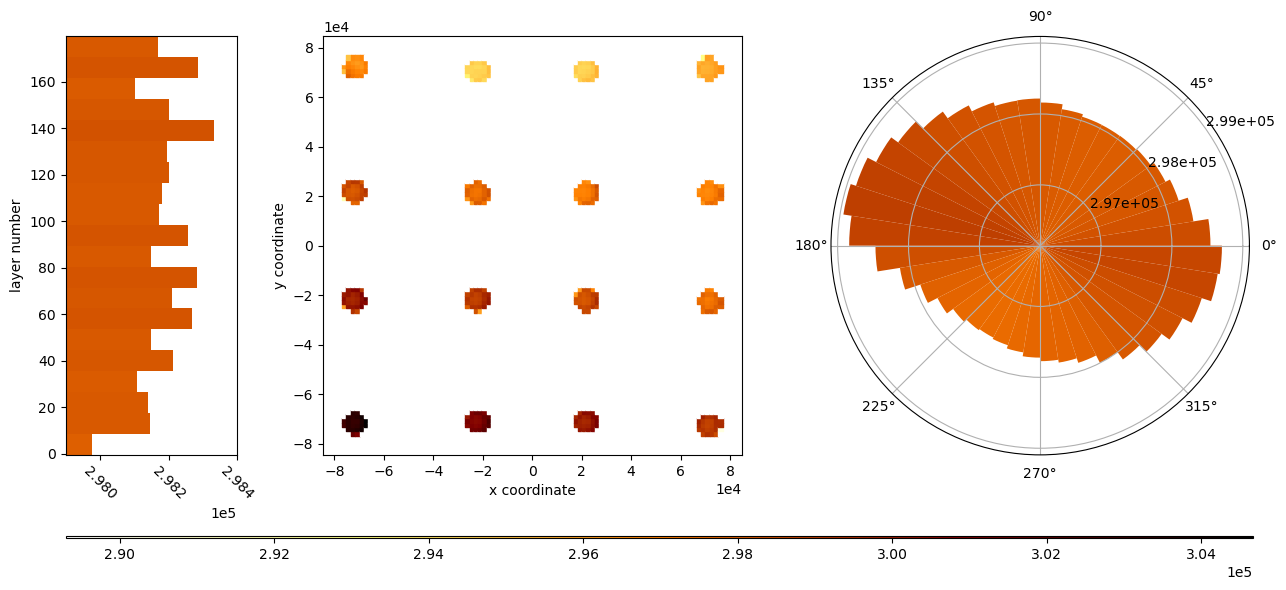

In [14]:
fig = plt.figure(figsize=(13.0,6.0))
ax_z,ax_xy,ax_th,vrange = fast_binning.plot_bins(fig,
                       "Photodiode",
                       XY_data,
                       th_data,
                       Zl_data,
                       "mean",
                       normalisation='linear')
fig.tight_layout()

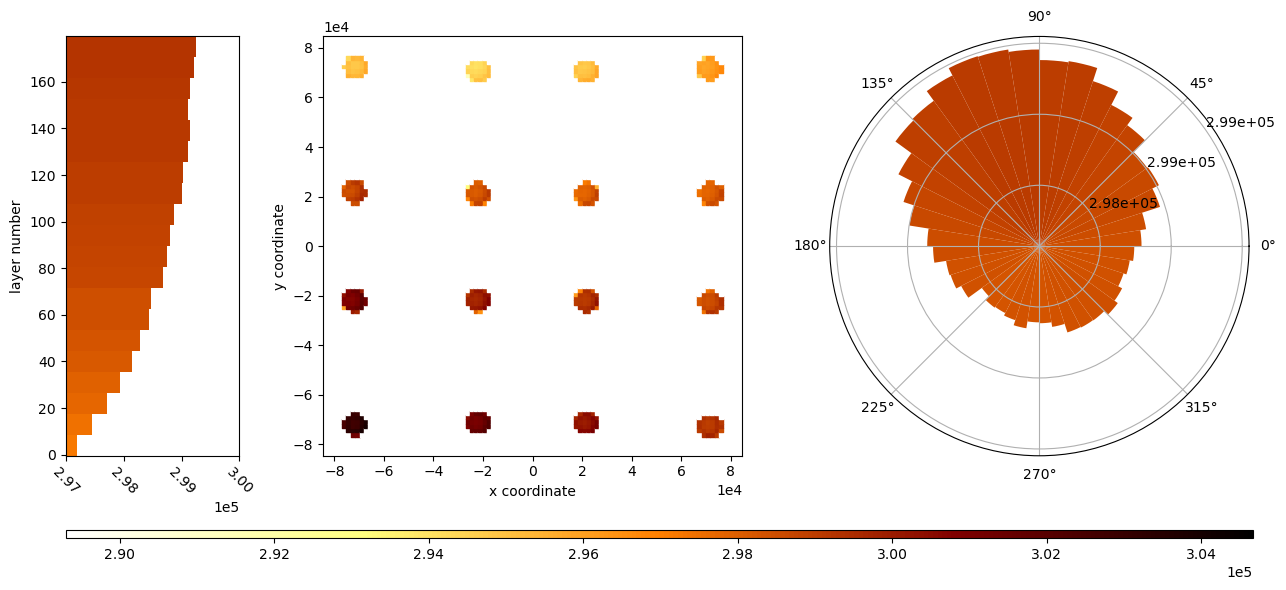

In [15]:
fig = plt.figure(figsize=(13.0,6.0))
ax_z,ax_xy,ax_th,vrange = fast_binning.plot_bins(fig,
                       "Photodiode",
                       XY_data_30Hz,
                       th_data_30Hz,
                       Zl_data_30Hz,
                       vrange=vrange,
                       quantity="mean",
                       normalisation='linear')
fig.tight_layout()

Total spatter area per unit of distance traversed along the scan path

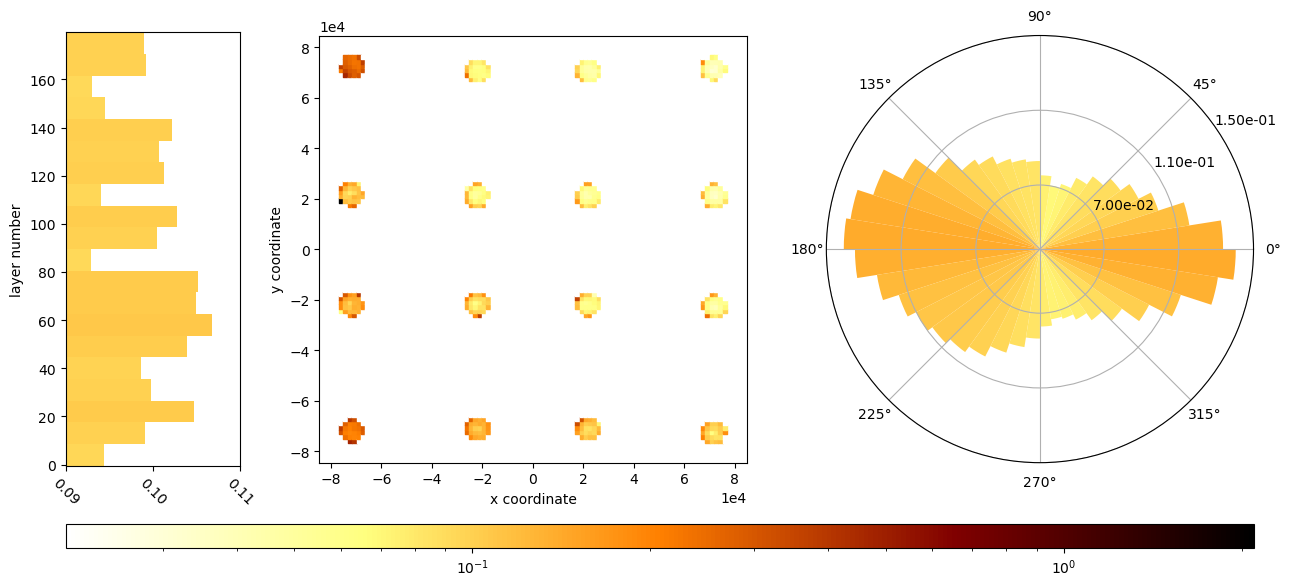

In [10]:
fig = plt.figure(figsize=(13.0,6.0))
ax_z,ax_xy,ax_th,vrange = fast_binning.plot_bins(fig,
                       "Spatter total area",
                       XY_data,
                       th_data,
                       Zl_data,
                       "per_traversed",
                       normalisation='log')
fig.tight_layout()

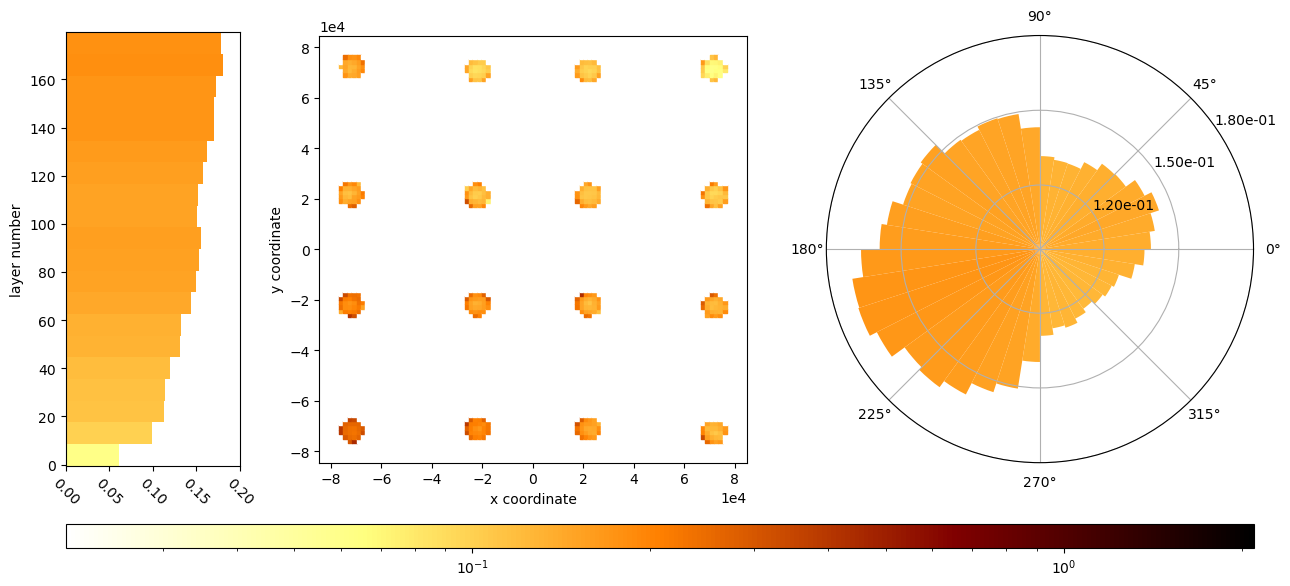

In [11]:
fig = plt.figure(figsize=(13.0,6.0))
ax_z,ax_xy,ax_th,vrange = fast_binning.plot_bins(fig,
                       "Spatter total area",
                       XY_data_30Hz,
                       th_data_30Hz,
                       Zl_data_30Hz,
                       vrange=vrange,
                       quantity="per_traversed",
                       normalisation='log')
fig.tight_layout()